 # Laboratorio 4 - Predicción en series de tiempo

## Tiara Ramírez - Valentina Cáceres

<div style="text-align: justify; line-height: 1.5;">
 
Un problema frecuente en Ingeniería es la regresión y la predicción. Esto es, identificar el valor de una variable de interés a partir de variables relacionadas en el caso de regresión, o predecir el valor futuro que tomará una variable de interés a partir de los valores históricos de esta misma variable. En este laboratorio realizaremos la predicción con un horizonte de 10 pasos temporales utilizando redes LSTM (Long Short-Term Memory networks). En el código adjunto, el modelo de predicción es capaz de predecir el valor futuro (10 muestras en el caso de este ejemplo) de nuestra señal de interés. En particular, acá se les entrega el código en Python + Torch para realizar la predicción de una señal sinusoidal sintetizada. Para esta sesión, se les pide:  

</div>

Epoch [10/100], Loss: 0.0527
Epoch [20/100], Loss: 0.0482
Epoch [30/100], Loss: 0.0372
Epoch [40/100], Loss: 0.0406
Epoch [50/100], Loss: 0.0393
Epoch [60/100], Loss: 0.0393
Epoch [70/100], Loss: 0.0443
Epoch [80/100], Loss: 0.0429
Epoch [90/100], Loss: 0.0402
Epoch [100/100], Loss: 0.0437


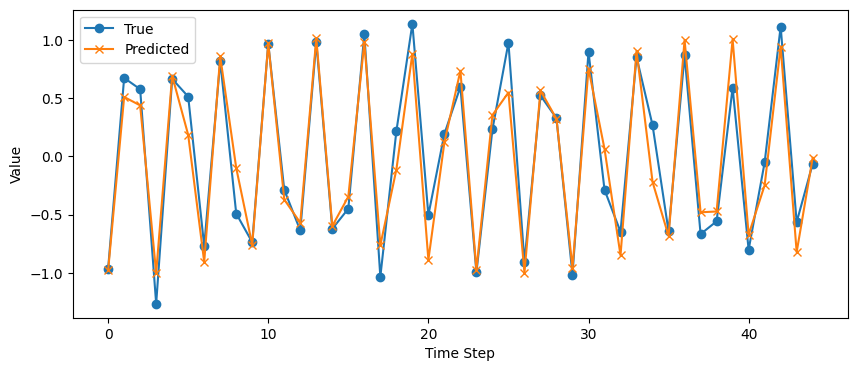

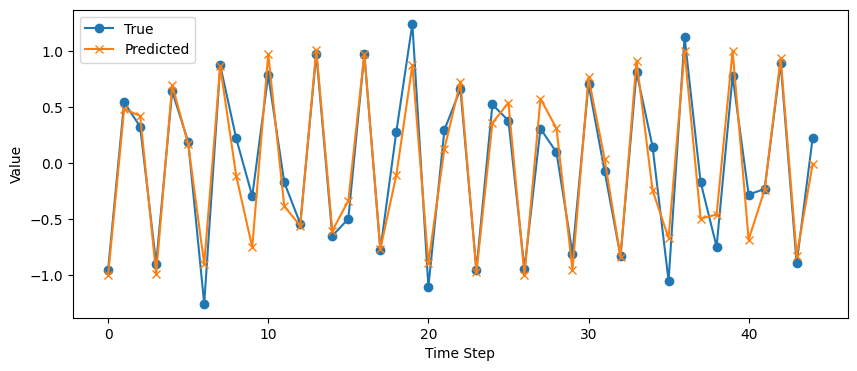

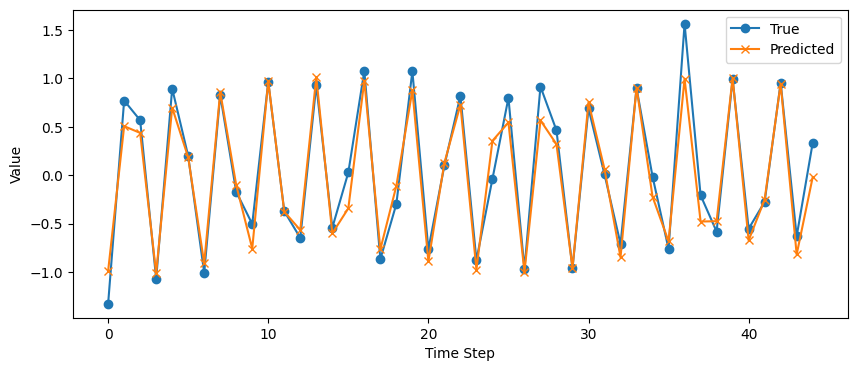

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Creamos una serie de tiempo sintetica (e.g., onda sinusoidal)
horizonte = 10        # horizonte de prediccion
f = 36                # frecuencia de la onda
varianza = 0.2          # varianza del ruido

# Funcion para generar una onda sinusoidal con ruido
def generate_sine_wave(seq_length, horizonte,  varianza, num_samples,):
    X = []
    y = []
    for i in range(num_samples):
        start = np.random.randint(0, 40)                                                            # inicio de la serie de tiempo
        time_steps = np.linspace(start, start + 10, seq_length)                                     # secuencia de tiempo
        data = np.sin(2 * np.pi * f * time_steps) + np.random.normal(0, varianza, seq_length)       # onda sinusoidal + ruido
        X.append(data[:-horizonte])                                                                 # secuencia de tiempo de entrada
        y.append(data[horizonte:])                                                                  # secuencia de tiempo de salida
    return np.array(X), np.array(y)                                                                 # convertir a numpy arrays

# Dataset personalizado para cargar los datos
class SineWaveDataset(Dataset):
    # Inicializa el dataset
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # convertir a tensor
        self.y = torch.tensor(y, dtype=torch.float32)   # convertir a tensor
        
    # Retorna el numero de muestras
    def __len__(self):
        return len(self.X)  
    
    # Retorna una muestra en la posicion idx
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Hyperparameters
seq_length = 50         # longitud de la secuencia
hidden_size = 20        # tamaño de la capa oculta
input_size = 1          # tamaño de la entrada
output_size = 1         # tamaño de la salida
num_layers = 2          # numero de capas
num_epochs = 100        # numero de epocas
batch_size = 16         # tamaño del lote
learning_rate = 0.001   # tasa de aprendizaje

# Cargar los datos
X, y = generate_sine_wave(seq_length, horizonte ,varianza, num_samples=500) # Generar datos
train_data = SineWaveDataset(X, y)                                          # Crear dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Crear dataloader

# Definir el modelo LSTM
class LSTMModel(nn.Module):
    # Inicializa el modelo
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()                                                   # Inicializa la clase base
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)          # LSTM layer
        self.fc = nn.Linear(hidden_size, output_size)                                       # Fully connected layer           
    
    # Forward pass
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)                   # Inicializa hidden state
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)                   # Inicializa cell state
        out, _ = self.lstm(x, (h0, c0))                                                     # Forward pass through LSTM layer                
        out = self.fc(out)                                                                  # Forward pass through Fully connected layer
        return out

# Inicializa el modelo, funcion objetivo y optimizador
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)   # Inicializa el modelo
criterion = nn.MSELoss()                                                                                            # Funcion objetivo                   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                                                  # Optimizador

# Entrenamiento del modelo
model.train()
for epoch in range(num_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):         # Iterar sobre los datos
        inputs = inputs.unsqueeze(-1)                                    # Add input dimension (batch_size, seq_length, input_size)
        targets = targets.unsqueeze(-1)                                  # Add target dimension

        # Forward pass
        outputs = model(inputs)                                          # Forward pass                              
        loss = criterion(outputs, targets)                               # Calcular la perdida    
    
        # Backward and optimize
        optimizer.zero_grad()                                            # Inicializar los gradientes      
        loss.backward()                                                  # Backward pass
        optimizer.step()                                                 # Optimizar    

    # Imprimir la perdida cada 10 epocas
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generate test data
test_X, test_y = generate_sine_wave(seq_length, horizonte,varianza, num_samples=10)
test_data = SineWaveDataset(test_X, test_y)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

#Switch to evaluation mode
model.eval()
predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(-1) # Add input dimension (1, seq_length, input_size)
        outputs = model(inputs)
        predictions.append(outputs.squeeze().numpy())

# Plot predictions vs true values
for i in range(3): # Plotting only 3 samples for visualization
    plt.figure(figsize=(10, 4))
    plt.plot(range(seq_length-horizonte), test_y[i], label="True", marker='o')
    plt.plot(range(seq_length-horizonte), predictions[i], label="Predicted", marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

<div style="text-align: justify; line-height: 1.5;">

**1.- Realizar la predicción para un horizonte de 10 muestras (correr el código, en esta notebook, o en sus computadores). ¿Qué funcional se debe minimizar para este problema de predicción? Reportar el error de entrenamiento en cada iteración.**  

</div>

<div style="text-align: justify; line-height: 1.5;">

Para este problema de predicción se utilizó la pérdida cuadrática media (MSE), la cual se minimiza para realizar una mejor predicción del problema. Esto se debe a que nos permite calcular el promedio de los errores al cuadrado entre las predicciones y los valores reales. Al minimizar la MSE, logramos que las predicciones del modelo se acerquen lo más posible a los valores reales, en este caso, a la señal original.
  
Los valores siguientes muestran el error durante el entrenamiento de la red neuronal. Podemos observar que, a medida que avanza el entrenamiento, este error se reduce prácticamente a 0. Solo con realizar el entrenamiento 30 veces podemos ver que es suficiente, ya que luego de estas iteraciones el error es 0. Además, tras completar el entrenamiento, se obtuvieron las gráficas de los tres primeros resultados del canal 1, con los cuales se puede comprobar que el valor predicho mediante la red neuronal es prácticamente 0.
  
No se realizó un procedimiento para una parada temprana, por lo cual el entrenamiento se ejecutó hasta completar las 100 iteraciones. Si se hubiera implementado una parada temprana, los entrenamientos habrían terminado una vez alcanzado un error igual a cero. Sin embargo, como no se realizó este procedimiento, se completaron las 100 iteraciones planeadas para la red neuronal.

</div>


 
Epoch [10/100], Loss: 0.0015  
Epoch [20/100], Loss: 0.0000  
Epoch [30/100], Loss: 0.0001  
Epoch [40/100], Loss: 0.0000  
Epoch [50/100], Loss: 0.0000  
Epoch [60/100], Loss: 0.0000  
Epoch [70/100], Loss: 0.0000  
Epoch [80/100], Loss: 0.0000  
Epoch [90/100], Loss: 0.0000  
Epoch [100/100], Loss: 0.0000 
  
<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta1.png" width="40%">
</div>

<div style="text-align: justify; line-height: 1.5;">

**2.- Cual es el desempeno al agregar ruido ( media 0, std=0.1; std=0,5) a la sinusoide?**  

</div>

<div style="text-align: justify; line-height: 1.5;">

Al añadir un ruido con una varianza de 0.1, se puede observar que los errores de entrenamiento aumentan considerablemente en comparación con los resultados obtenidos anteriormente, ya que en este caso no se logra alcanzar un error de entrenamiento igual a cero. Aun así, podemos ver que estos errores son cercanos a cero, por lo cual no se considerarían resultados malos. Además, en las gráficas obtenidas tras realizar el entrenamiento, se puede observar que la señal resultante es bastante parecida a la real, lo cual se podría considerar válido.  

</div>
  
Epoch [10/100], Loss: 0.0209  
Epoch [20/100], Loss: 0.0114  
Epoch [30/100], Loss: 0.0074  
Epoch [40/100], Loss: 0.0109  
Epoch [50/100], Loss: 0.0106  
Epoch [60/100], Loss: 0.0099  
Epoch [70/100], Loss: 0.0085  
Epoch [80/100], Loss: 0.0108  
Epoch [90/100], Loss: 0.0100  
Epoch [100/100], Loss: 0.0073  
  
<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta2std0.1.png" width="40%">
</div>  
  

<div style="text-align: justify; line-height: 1.5;">

Al aumentar la varianza a 0.5, se puede observar que el error de entrenamiento aumentó, lo que permite verificar que, al incrementar la varianza, los resultados obtenidos serían peores. Además, esto se puede comprobar observando las gráficas obtenidas tras finalizar el entrenamiento, ya que, aunque en algunos puntos muestran una tendencia hacia la señal original, no se podrían considerar similares a la original.
  
Por lo tanto, se puede concluir que al agregar ruido a la señal, este afecta el resultado del entrenamiento de la red neuronal. Sin embargo, el factor que más influye es el valor de la varianza, ya que si este toma un valor muy alto, el entrenamiento de la red neuronal se ve afectado significativamente. Por otro lado, si el valor de la varianza no es muy alto, el resultado obtenido del entrenamiento puede considerarse válido. Esto se evidencia con un valor de varianza de 0.1, donde los resultados obtenidos fueron buenos.

</div>
  
Epoch [10/100], Loss: 0.3222  
Epoch [20/100], Loss: 0.2211  
Epoch [30/100], Loss: 0.2402  
Epoch [40/100], Loss: 0.2444  
Epoch [50/100], Loss: 0.2638  
Epoch [60/100], Loss: 0.2382  
Epoch [70/100], Loss: 0.3207  
Epoch [80/100], Loss: 0.3123  
Epoch [90/100], Loss: 0.2593  
Epoch [100/100], Loss: 0.2542  
  
<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta2std0.5.png" width="40%">
</div>  

  
  

<div style="text-align: justify; line-height: 1.5;">

**3.- Al agregar ruido m=0, std=0.2. Empeora el desempeno si extendemos el horizonte de prediccion?**  

</div> 
 
<div style="text-align: justify; line-height: 1.5;">

Para este punto se realizaron tres pruebas. Primero, se dejó el horizonte en 10, como en las pruebas anteriores. Luego, se aumentó el horizonte a 20, y, por último, se disminuyó el horizonte a 5. En todas estas pruebas, se observó que los valores de los errores de entrenamiento no cambiaron mucho. Las tres pruebas obtuvieron valores muy cercanos, lo que permite concluir que variar el horizonte de predicción no afecta significativamente los valores obtenidos al finalizar el entrenamiento, ya que los errores son similares y las gráficas resultantes de cada prueba también lo son.
  
Sin embargo, al haber aumentado la varianza a 0.2, los valores obtenidos no son tan precisos como los que se obtuvieron con una varianza de 0.1, aunque siguen siendo mejores que los obtenidos con una varianza de 0.5. Esto confirma lo mencionado anteriormente: al aumentar la varianza, los resultados obtenidos empeoran gradualmente.
  
Al dejar el horizonte en 10, los resultados son los siguientes:

</div>   

 
  
Epoch [10/100], Loss: 0.0490  
Epoch [20/100], Loss: 0.0368  
Epoch [30/100], Loss: 0.0370  
Epoch [40/100], Loss: 0.0365  
Epoch [50/100], Loss: 0.0388  
Epoch [60/100], Loss: 0.0380  
Epoch [70/100], Loss: 0.0428  
Epoch [80/100], Loss: 0.0412  
Epoch [90/100], Loss: 0.0455  
Epoch [100/100], Loss: 0.0436  

<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta3std0.2Horizonte10.png" width="40%">
</div>  
   

Al aumentar el horizonte a 20 los resultados son los siguientes:  
  
Epoch [10/100], Loss: 0.0563  
Epoch [20/100], Loss: 0.0413  
Epoch [30/100], Loss: 0.0343  
Epoch [40/100], Loss: 0.0486  
Epoch [50/100], Loss: 0.0389  
Epoch [60/100], Loss: 0.0376  
Epoch [70/100], Loss: 0.0367  
Epoch [80/100], Loss: 0.0322  
Epoch [90/100], Loss: 0.0491  
Epoch [100/100], Loss: 0.0438  
  
<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta3std0.2Horizonte20.png" width="40%">
</div>   

Al disminuir el horizonte a 5 los resultados son los siguientes:  

Epoch [10/100], Loss: 0.0455  
Epoch [20/100], Loss: 0.0450  
Epoch [30/100], Loss: 0.0473  
Epoch [40/100], Loss: 0.0467  
Epoch [50/100], Loss: 0.0362  
Epoch [60/100], Loss: 0.0328  
Epoch [70/100], Loss: 0.0410  
Epoch [80/100], Loss: 0.0373  
Epoch [90/100], Loss: 0.0434  
Epoch [100/100], Loss: 0.0565  
  
<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta3std0.2Horizonte5.png" width="40%">
</div>   
  
  
  
  

Epoch [10/100], Loss: 0.5335
Epoch [20/100], Loss: 0.3544
Epoch [30/100], Loss: 0.4850
Epoch [40/100], Loss: 0.4470
Epoch [50/100], Loss: 0.4908
Epoch [60/100], Loss: 0.1166
Epoch [70/100], Loss: 0.0788
Epoch [80/100], Loss: 0.0571
Epoch [90/100], Loss: 0.0632
Epoch [100/100], Loss: 0.0481


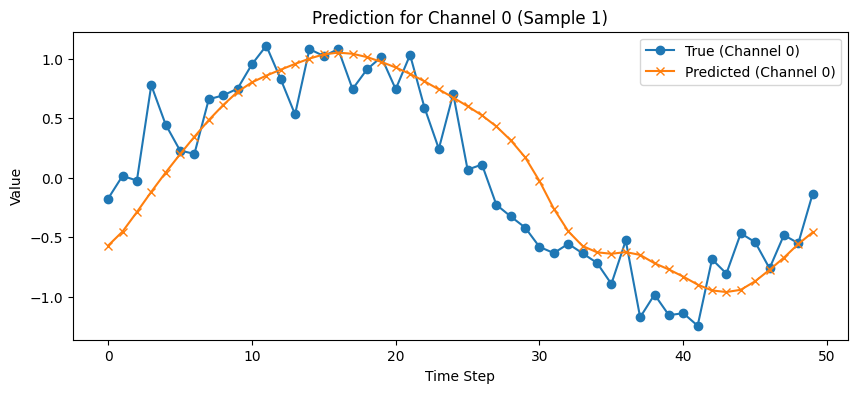

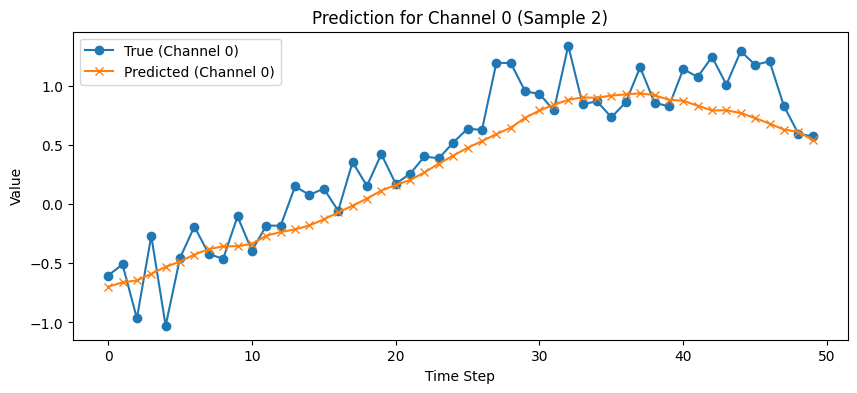

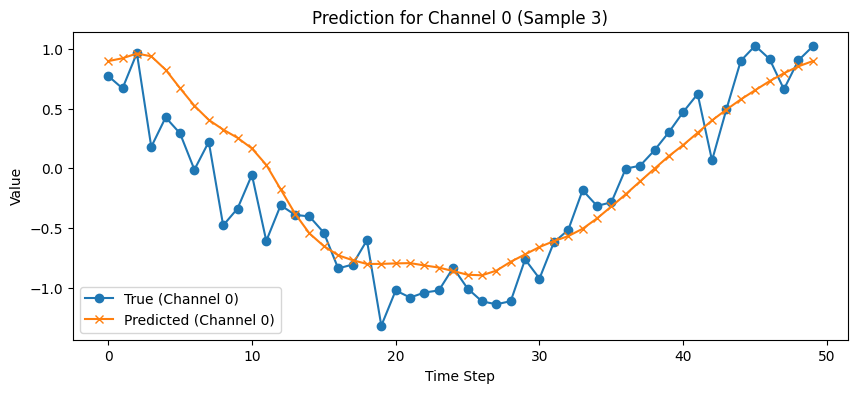

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Generar una serie de tiempo multidimensional con sinusoides y ruido
def generate_multichannel_sine_wave(seq_length, horizonte, varianza, num_samples, num_channels):
    X = []
    y = []
    for _ in range(num_samples):
        time_steps = np.linspace(0, 50, seq_length + horizonte)
        data = []
        base_freq = np.random.uniform(0.02, 0.1)  # Frecuencia base para las sinusoides
        for _ in range(num_channels):
            freq_variation = np.random.uniform(-0.01, 0.01)
            channel = np.sin(2 * np.pi * (base_freq + freq_variation) * time_steps) + np.random.normal(0, varianza, len(time_steps))
            data.append(channel)
        data = np.array(data).T  # Transponer para tener la forma (seq_length + horizonte, num_channels)
        X.append(data[:seq_length, :])  # Usamos los primeros `seq_length` pasos como entrada
        y.append(data[seq_length:seq_length + horizonte, 0])  # Predecimos el canal 0 en los siguientes `horizonte` pasos
    return np.array(X), np.array(y)

# Dataset personalizado
class MultichannelSineWaveDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Modelo LSTM
class MultichannelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultichannelLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # Predecimos para cada paso de la secuencia
        return out[:, -horizonte:, :]  # Solo nos interesan los últimos `horizonte` pasos

# Parámetros
seq_length = 200         # Longitud de la secuencia
horizonte = 50          # Horizonte de predicción
varianza = 0.2          # Varianza del ruido
num_channels = 3        # Número de canales
hidden_size = 20        # Tamaño de la capa oculta
num_layers = 2          # Número de capas LSTM
num_epochs = 100        # Número de épocas
batch_size = 16         # Tamaño del lote
learning_rate = 0.001   # Tasa de aprendizaje

# Generar datos
X, y = generate_multichannel_sine_wave(seq_length, horizonte, varianza, num_samples=500, num_channels=num_channels)
train_data = MultichannelSineWaveDataset(X, y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Inicializar modelo, función de pérdida y optimizador
model = MultichannelLSTM(input_size=num_channels, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento
model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs).squeeze(-1)  # Elimina la última dimensión (innecesaria)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Generar datos de prueba
test_X, test_y = generate_multichannel_sine_wave(seq_length, horizonte, varianza, num_samples=10, num_channels=num_channels)
test_data = MultichannelSineWaveDataset(test_X, test_y)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Evaluación
model.eval()
predictions = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs).squeeze(-1)  # Elimina la última dimensión
        predictions.append(outputs.numpy())

# Visualización
for i in range(3):  # Graficar los primeros 3 ejemplos
    plt.figure(figsize=(10, 4))
    plt.plot(range(horizonte), test_y[i], label="True (Channel 0)", marker='o')
    plt.plot(range(horizonte), predictions[i].flatten(), label="Predicted (Channel 0)", marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.title(f"Prediction for Channel 0 (Sample {i+1})")
    plt.show()



<div style="text-align: justify; line-height: 1.5;">

**4.-Elegir serie de tiempo multidimensional y hacer estimación y predicción de uno de los canales a partir de la informacion de los otros canales.**  

</div> 

<div style="text-align: justify; line-height: 1.5;">

Al añadir una serie de tiempo multidimensional, en este caso una serie de sinusoidales variables y sin agregar ruido, se pudo observar que los errores de los primeros entrenamientos fueron bastante altos. Sin embargo, a medida que avanzaron los entrenamientos, estos lograron disminuir significativamente, lo que demuestra que, a pesar de trabajar con una serie de tiempo multidimensional, la red neuronal es capaz de alcanzar un valor aceptable.

Por otro lado, al añadir ruido a la serie de tiempo multidimensional con una varianza de 0.2, los valores de los errores en cada entrenamiento fueron bastante altos. Aunque disminuyen progresivamente, esta disminución no es suficiente para considerarlos valores aceptables. Al observar las gráficas obtenidas al finalizar los entrenamientos, se puede notar que, aunque tienen una tendencia hacia la señal original, el ruido es tan grande que deforma considerablemente la señal obtenida. 

</div>   
  
Sin error  
  
Epoch [10/100], Loss: 0.5689  
Epoch [20/100], Loss: 0.6329  
Epoch [30/100], Loss: 0.1046  
Epoch [40/100], Loss: 0.0146  
Epoch [50/100], Loss: 0.0101  
Epoch [60/100], Loss: 0.0146  
Epoch [70/100], Loss: 0.0083  
Epoch [80/100], Loss: 0.0022  
Epoch [90/100], Loss: 0.0020  
Epoch [100/100], Loss: 0.0025  
   
<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta4SinRuido.png" width="40%">
</div>   
  
  
Con error std=0.2  

Epoch [10/100], Loss: 0.5335  
Epoch [20/100], Loss: 0.3544  
Epoch [30/100], Loss: 0.4850  
Epoch [40/100], Loss: 0.4470  
Epoch [50/100], Loss: 0.4908  
Epoch [60/100], Loss: 0.1166  
Epoch [70/100], Loss: 0.0788  
Epoch [80/100], Loss: 0.0571  
Epoch [90/100], Loss: 0.0632  
Epoch [100/100], Loss: 0.0481  
  

<div style="text-align: center;">
    <img src="ImagenesLab4\Pregunta4ConRuido.png" width="40%">
</div>   